### Import libraries

In [1]:
import pandas as pd
import os
import shutil
import sys
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import matplotlib.pyplot as plt
# import tensorflow as tf
from tensorflow import keras
import tensorflow

from  tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

### Check out the directories

In [6]:
# inserting the parent directory into current path
sys.path.insert(1, '../Lung_Disease_Detection_Deeplearning/')

In [10]:
os.listdir('../Dataset_augmented_subfolders/')

['Test', 'Train', 'val']

In [12]:
os.listdir('../\Dataset_augmented_subfolders/Train/')

['COVID', 'NORMAL']

In [13]:
Train_NORMAL = os.listdir('../Dataset_augmented_subfolders/Train/NORMAL/')
print('Train_NORMAL = ', len(Train_NORMAL))

Train_NORMAL =  563


In [14]:
Train_Covid = os.listdir('../Dataset_augmented_subfolders/Train/COVID/')
print('Train_Covid = ', len(Train_Covid))

Train_Covid =  584


## Quick look to the images 

In [15]:
print('names \n ', Train_NORMAL[0], '\n' ,Train_Covid[0])

names 
  augmented_normal_0_4086.jpeg 
 augmented_covid_0_4049.jpeg


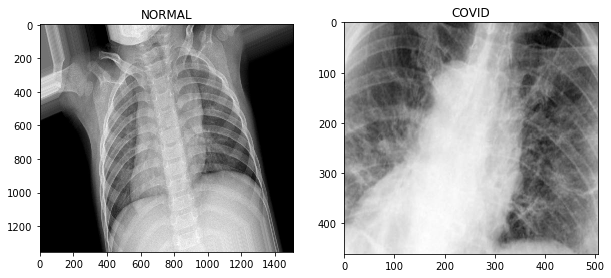

In [17]:
# ref https://www.kaggle.com/feyzazkefe/pneumonia-detection-using-cnn-89-42-acc

img_name = 'augmented_normal_0_4086.jpeg '
img_normal = load_img('../Dataset_augmented_subfolders/Train/NORMAL/' + img_name)

img_name_1 = 'augmented_covid_0_4049.jpeg'
img_pneumonia = load_img('../Dataset_augmented_subfolders/Train/COVID/' + img_name_1)

fig, axs = plt.subplots(1,2,figsize=(10,6))
axs[0].imshow(img_normal)
axs[0].set_title("NORMAL")
axs[1].imshow(img_pneumonia)
axs[1].set_title("COVID");

plt.savefig("../Assets/plot_01_assets_1.png")

### Assemble CNN model

In [18]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3),
                 activation='relu',
                 input_shape=(224,224,3)))
model.add(Conv2D(64, kernel_size=(3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

### Metrics

In [19]:
metr_auc = tensorflow.keras.metrics.AUC(num_thresholds=200, curve='ROC')
TP = tensorflow.keras.metrics.TruePositives(thresholds=None, name=None, dtype=None)
TN = tensorflow.keras.metrics.TrueNegatives(thresholds=None, name=None, dtype=None)
FP = tensorflow.keras.metrics.FalsePositives(thresholds=None, name=None, dtype=None)
FN = tensorflow.keras.metrics.FalseNegatives(thresholds=None, name=None, dtype=None)

Recall_metr = tensorflow.keras.metrics.Recall(thresholds=None, top_k=None, 
                class_id=None, name=None, dtype=None)
# mtr_list = ['accuracy','mse', metr_auc,TP,TN,FP,FN]
mtr_list = ['accuracy', metr_auc]

In [20]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer='adam', 
              metrics=mtr_list)


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 54, 64)        0

### Prepare the data

In [21]:
train_datagen = image.ImageDataGenerator(
                featurewise_center=False, samplewise_center=False,
                featurewise_std_normalization=False, samplewise_std_normalization=False,
                zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
                height_shift_range=0.0, brightness_range=None, shear_range=0.2, zoom_range=0.2,
                channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
                horizontal_flip=True, vertical_flip=False, rescale=1./255,
                preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None)

In [22]:
val_dataset = image.ImageDataGenerator(rescale=1./255)

In [23]:
train_generator = train_datagen.flow_from_directory(
                    directory='../Dataset_augmented_subfolders/Train/',
                    target_size=(224,224),
                    color_mode="rgb",
                    classes=None,
                    class_mode="binary",
                    batch_size=32,
                    shuffle=True,
                    seed=1234,
                    save_to_dir=None,
                    save_prefix="",
                    save_format="png",
                    follow_links=False,
                    subset=None,
                    interpolation="nearest")

Found 1147 images belonging to 2 classes.


In [24]:
train_generator.class_indices

{'COVID': 0, 'NORMAL': 1}

In [25]:
validation_generator = val_dataset.flow_from_directory(
                        directory='../Dataset_augmented_subfolders/val/',
                        target_size=(224,224),
                        color_mode="rgb",
                        classes=None,
                        class_mode="binary",
                        batch_size=32,
                        shuffle=True,
                        seed=1234,
                        save_to_dir=None,
                        save_prefix="",
                        save_format="png",
                        follow_links=False,
                        subset=None,
                        interpolation="nearest")

Found 570 images belonging to 2 classes.


In [26]:
validation_generator.class_indices

{'COVID': 0, 'NORMAL': 1}

In [56]:
test_dataset = image.ImageDataGenerator(rescale=1./255)

In [57]:
test_generator = test_dataset.flow_from_directory(
                        directory='../Dataset_augmented_subfolders/Test/',
                        target_size=(224,224),
                        color_mode="rgb",
                        classes=None,
                        class_mode="binary",
                        batch_size=32,
                        shuffle=True,
                        seed=1234,
                        save_to_dir=None,
                        save_prefix="",
                        save_format="png",
                        follow_links=False,
                        subset=None,
                        interpolation="nearest")

Found 200 images belonging to 2 classes.


In [34]:
# validation_generator = test_dataset.flow_from_directory(
#                         '../COVID_19/Dataset/val/',
#                         target_size =(224,224),
#                         batch_size = 32,
#                         class_mode ='binary')

### Show some images after data augmentation

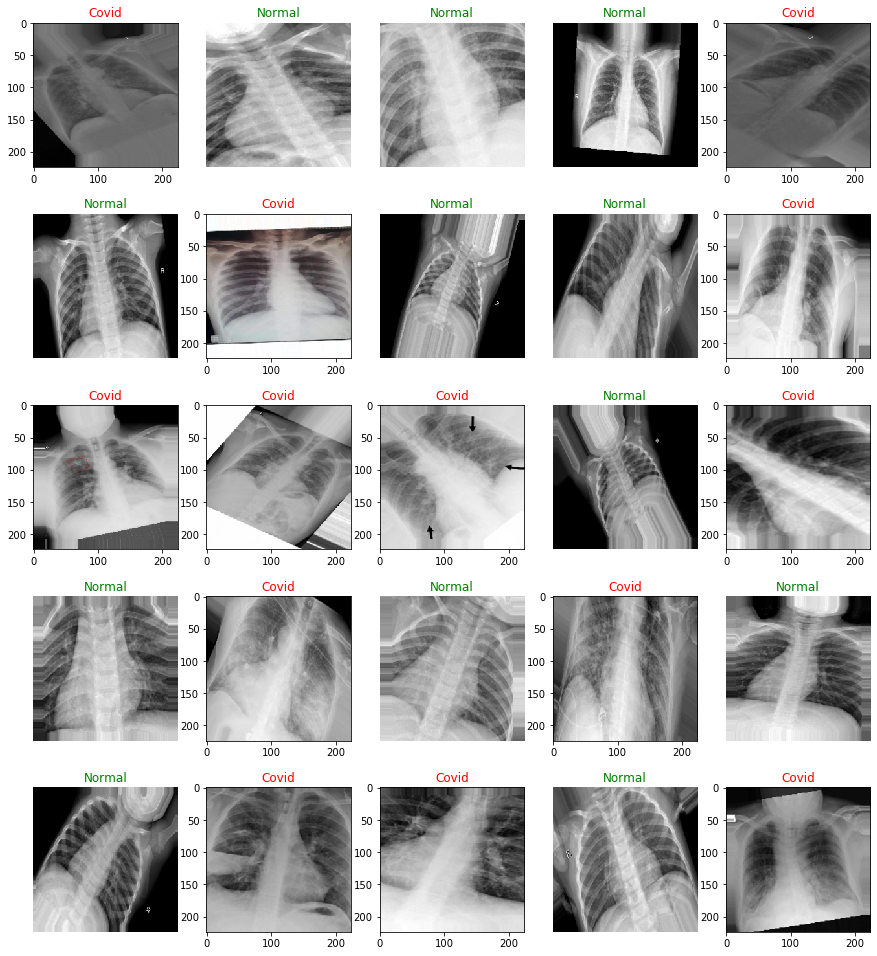

In [27]:
# ref https://www.kaggle.com/feyzazkefe/pneumonia-detection-using-cnn-89-42-acc
image_batch, label_batch = next(iter(train_generator))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(15, 17))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        if label_batch[n] ==0:
            tit = plt.title("Covid")
            plt.setp(tit, color='r')

        else:
            tit = plt.title("Normal")
            plt.setp(tit, color='g')
            plt.axis("off")

show_batch(image_batch, label_batch)
plt.savefig("../Assets/plot_01_assets_2.png")

### Train the CNN model

In [59]:
model_history = model.fit_generator(
                generator=train_generator, steps_per_epoch=10, epochs=20, verbose=1, callbacks=None,
                validation_data= validation_generator, validation_steps=2, validation_freq=1,
                class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False,
                shuffle=True, initial_epoch=0
            )

Epoch 1/20
10/10 [==============================] - 15s 2s/step - loss: 0.4859 - accuracy: 0.8094 - auc: 0.8648 - val_loss: 0.4023 - val_accuracy: 0.8594 - val_auc: 0.9235
Epoch 2/20
10/10 [==============================] - 15s 2s/step - loss: 0.4939 - accuracy: 0.7594 - auc: 0.8307 - val_loss: 0.4660 - val_accuracy: 0.7969 - val_auc: 0.9230
Epoch 3/20
10/10 [==============================] - 15s 1s/step - loss: 0.5450 - accuracy: 0.7429 - auc: 0.8082 - val_loss: 0.4827 - val_accuracy: 0.7344 - val_auc: 0.8749
Epoch 4/20
10/10 [==============================] - 15s 1s/step - loss: 0.5667 - accuracy: 0.6625 - auc: 0.7446 - val_loss: 0.4868 - val_accuracy: 0.7969 - val_auc: 0.8853
Epoch 5/20
10/10 [==============================] - 15s 2s/step - loss: 0.5328 - accuracy: 0.6906 - auc: 0.8061 - val_loss: 0.4191 - val_accuracy: 0.7812 - val_auc: 0.9324
Epoch 6/20
10/10 [==============================] - 15s 1s/step - loss: 0.6091 - accuracy: 0.5969 - auc: 0.7193 - val_loss: 0.6193 - val_acc

### Plot the History

In [60]:
# list all data in history
print('len(model_history.history.keys()) \n', 
      len(model_history.history.keys()),'\n')
print(model_history.history.keys())

len(model_history.history.keys()) 
 6 

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])


In [61]:
model_history_df = pd.DataFrame(model_history.history)
model_history_df

,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.485907,0.809375,0.864810,0.402283,0.859375,0.923529
1,0.493867,0.759375,0.830747,0.466046,0.796875,0.923039
2,0.544983,0.742857,0.808206,0.482736,0.734375,0.874875
3,0.566687,0.662500,0.744602,0.486790,0.796875,0.885254
4,0.532751,0.690625,0.806069,0.419116,0.781250,0.932432
5,0.609115,0.596875,0.719266,0.619273,0.703125,0.879277
6,0.566085,0.681250,0.753312,0.467831,0.812500,0.916416
7,0.480464,0.787302,0.841745,0.414143,0.906250,0.932063
8,0.472763,0.825397,0.870302,0.476173,0.828125,0.894581
9,0.497120,0.793750,0.849286,0.421190,0.812500,0.918137


In [62]:
model_history_df.columns

Index(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'], dtype='object')

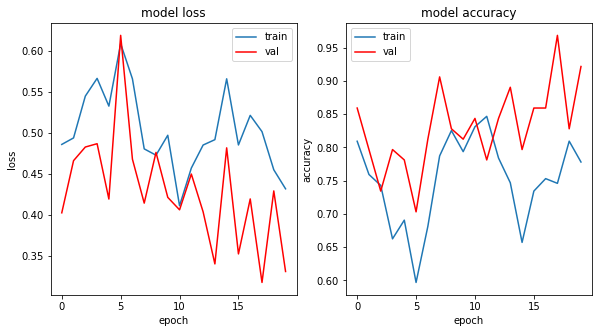

In [63]:
# plt.figure(figsize=(15,17))
# columns = ['loss', 'accuracy', 'mse', 'auc', 'true_positives', 'true_negatives',
#            'false_positives', 'false_negatives']
plt.figure(figsize=(15,17))
columns = ['loss', 'accuracy']
for i,col in enumerate(columns):
    
    plt.subplot(3, 3, i+1)
    
    plt.plot(model_history_df[col])
    plt.plot(model_history_df['val_'+col], color='red')
    plt.title('model '+col)
    plt.ylabel(col)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    
plt.savefig("../Figures/plot_01_1.png")

In [98]:
model.save("../Codes/Models/model_twoClass.h5")

### Model evaluation

In [64]:
model.evaluate_generator(train_generator)

[0.3659663498401642, 0.8718395829200745, 0.9419602751731873]

In [65]:
model.evaluate_generator(validation_generator)

[0.3752581477165222, 0.8649122714996338, 0.9376977682113647]

In [66]:
model.evaluate_generator(test_generator)

[0.3398384153842926, 0.8999999761581421, 0.9648000001907349]

### Test model on test set data

Check out the Normal cases data from normal test directory

In [95]:
NORMAL_img_list = os.listdir('../Dataset_augmented_subfolders/Test/NORMAL/')
NORMAL_img_list = [i for i in NORMAL_img_list if i !='.DS_Store']
# plt.figure(figsize=(20, 10)) 
labels = []
for i, img in enumerate(NORMAL_img_list):
    path_to_img = '../Dataset_augmented_subfolders/Test/NORMAL/'+str(img)
    img = load_img(path_to_img, target_size=(224, 224))
    img = img_to_array(img)
    # expand dimensions to match the shape of model input
    img = np.expand_dims(img, axis=0)
    feature_output = model.predict_classes(img)
#     lab = np.argmax(feature_output, axis=-1)
    labels.append(feature_output[0][0])
    
# print(labels)

labels2 = pd.DataFrame(labels,columns=['categ'])
labels2['categ'].value_counts(normalize=True)

1    0.97
0    0.03
Name: categ, dtype: float64

check out the covid cases from covid test directory

In [96]:
Covid_img_list = os.listdir('../Dataset_augmented_subfolders/Test/COVID/')
Covid_img_list = [i for i in Covid_img_list if i !='.DS_Store']
labels = []

for i, img in enumerate(Covid_img_list):
    path_to_img = '../Dataset_augmented_subfolders/Test/COVID/'+str(img)
    img = load_img(path_to_img, target_size=(224, 224))
    img = img_to_array(img)
    # expand dimensions to match the shape of model input
    img = np.expand_dims(img, axis=0)
    # Generate feature output by predicting on the input image
    feature_output = model.predict_classes(img)
    score = predictions[0]
    labels.append(feature_output[0][0])
    
# print(labels)
labels2 = pd.DataFrame(labels,columns=['categ'])
labels2['categ'].value_counts(normalize=True)    

0    0.65
1    0.35
Name: categ, dtype: float64

double check the model using generators and evalute funtion

In [52]:
model.evaluate(train_generator)

36/36 [==============================] - 18s 500ms/step - loss: 0.5238 - accuracy: 0.8370 - auc: 0.8996


[0.5238319039344788, 0.8369659781455994, 0.8996174335479736]

In [39]:
model.evaluate(validation_generator)

18/18 [==============================] - 6s 328ms/step - loss: 0.5304 - accuracy: 0.8053 - auc: 0.8951


[0.5304375290870667, 0.8052631616592407, 0.8951000571250916]

### Transfer learning using InceptionV3 models

In [20]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Input


# create the base pre-trained model
# base_model = InceptionV3(weights='imagenet', include_top=False)
# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(224, 224, 3))
base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=True)
# add a global spatial average pooling layer
x = base_model.output
# x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 1 classes
predictions = Dense(1, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
              metrics=mtr_list)

Train the model on the new data for a few epochs

In [21]:
model_history = model.fit_generator(
                generator=train_generator, steps_per_epoch=10, epochs=10, verbose=1, callbacks=None,
                validation_data= validation_generator, validation_steps=2, validation_freq=1,
                class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False,
                shuffle=True, initial_epoch=0
            )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
10/10 [==============================] - 8s 821ms/step - loss: 0.0000e+00 - accuracy: 0.5033 - auc: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 2/10
10/10 [==============================] - 7s 695ms/step - loss: 0.0000e+00 - accuracy: 0.5133 - auc: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 3/10
10/10 [==============================] - 7s 697ms/step - loss: 0.0000e+00 - accuracy: 0.4967 - auc: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 4/10
10/10 [==============================] - 7s 720ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - auc: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 5/10
10/10 [==============================] - 7s 706ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - auc: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 6/10
10/

In [22]:
# create the base pre-trained model
# base_model = InceptionV3(weights='imagenet', include_top=False)
# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(224, 224, 3))
base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=True)
# add a global spatial average pooling layer
x = base_model.output
# x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 1 classes
predictions = Dense(1, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer='adam', 
              metrics=mtr_list)

In [23]:
model_history = model.fit_generator(
                generator=train_generator, steps_per_epoch=10, epochs=10, verbose=1, callbacks=None,
                validation_data= validation_generator, validation_steps=2, validation_freq=1,
                class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False,
                shuffle=True, initial_epoch=0
            )

Epoch 1/10
10/10 [==============================] - 8s 818ms/step - loss: 7.7771 - accuracy: 0.4900 - auc: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 2/10
10/10 [==============================] - 7s 724ms/step - loss: 7.3705 - accuracy: 0.5167 - auc: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 3/10
10/10 [==============================] - 7s 710ms/step - loss: 7.4721 - accuracy: 0.5100 - auc: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 4/10
10/10 [==============================] - 8s 760ms/step - loss: 7.5770 - accuracy: 0.5031 - auc: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 5/10
10/10 [==============================] - 7s 731ms/step - loss: 7.5738 - accuracy: 0.5033 - auc: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 6/10
10/10 [==============================] - 7s 725ms/step - loss: 7.3705 - accuracy: 0.5167 - auc: 0.5000 - val_loss: 7.62

In [97]:
# # at this point, the top layers are well trained and we can start fine-tuning
# # convolutional layers from inception V3. We will freeze the bottom N layers
# # and train the remaining top layers.

# # let's visualize layer names and layer indices to see how many layers
# # we should freeze:
# for i, layer in enumerate(base_model.layers):
#     print(i, layer.name)

# # we chose to train the top 2 inception blocks, i.e. we will freeze
# # the first 249 layers and unfreeze the rest:
# for layer in model.layers[:249]:
#     layer.trainable = False
# for layer in model.layers[249:]:
#     layer.trainable = True

# # we need to recompile the model for these modifications to take effect
# # we use SGD with a low learning rate
# from tensorflow.keras.optimizers import SGD
# model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), 
#               loss='categorical_crossentropy')

# # we train our model again (this time fine-tuning the top 2 inception blocks
# # alongside the top Dense layers
# model_history = model.fit_generator(
#                 generator=train_generator, steps_per_epoch=10, epochs=10, verbose=1, callbacks=None,
#                 validation_data= validation_generator, validation_steps=2, validation_freq=1,
#                 class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False,
#                 shuffle=True, initial_epoch=0
#             )

In [51]:
Covid_img_list = os.listdir('../Dataset/Train/Covid/')
Covid_img_list = [i for i in Covid_img_list if i !='.DS_Store']
# plt.figure(figsize=(20, 10)) 
labels = []
for i, img in enumerate(Covid_img_list):
    path_to_img = '../Dataset/Train/Covid/'+str(img)
    img = load_img(path_to_img, target_size=(224, 224))
    img = img_to_array(img)
    # expand dimensions to match the shape of model input
    img = np.expand_dims(img, axis=0)
    # Generate feature output by predicting on the input image
    feature_output = model.predict(img)
    lab = np.argmax(feature_output, axis=-1)
    labels.append(lab[0])
print(labels)

labels2 = pd.DataFrame(labels,columns=['categ'])
labels2['categ'].value_counts(normalize=False)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


0    166
Name: categ, dtype: int64

In [52]:
NORMAL_img_list = os.listdir('../Dataset/Train/NORMAL/')
NORMAL_img_list = [i for i in NORMAL_img_list if i !='.DS_Store']
# plt.figure(figsize=(20, 10)) 
labels = []
for i, img in enumerate(NORMAL_img_list):
    path_to_img = '../Dataset/Train/NORMAL/'+str(img)
    img = load_img(path_to_img, target_size=(224, 224))
    img = img_to_array(img)
    # expand dimensions to match the shape of model input
    img = np.expand_dims(img, axis=0)
    # Generate feature output by predicting on the input image
    feature_output = model.predict(img)
    lab = np.argmax(feature_output, axis=-1)
    labels.append(lab[0])
print(labels)

labels2 = pd.DataFrame(labels,columns=['categ'])
labels2['categ'].value_counts(normalize=False)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


0    166
Name: categ, dtype: int64